# Kernel methods for machine learning: Data Challenge

Florent MICHEL (MVA)

#### Imports and functions

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Load the data

In [6]:
CSV_FILE_X_TRAIN = 'Xtr.csv'
CSV_FILE_X_TEST = 'Xte.csv'
CSV_FILE_Y_TRAIN = 'Ytr.csv'

x_train = np.array(pd.read_csv(CSV_FILE_X_TRAIN, header=None, sep=',', usecols=range(3072)))
x_test = np.array(pd.read_csv(CSV_FILE_X_TEST, header=None, sep=',', usecols=range(3072)))
y_train = np.array(pd.read_csv(CSV_FILE_Y_TRAIN, sep=',', usecols=[1])).squeeze()

print(x_train.shape, y_train.shape, x_test.shape)

(5000, 3072) (5000,) (2000, 3072)


#### Image visualisation

In [7]:
def normalize(x):
    """Normalize to values between 0 and 1"""

    return (x - x.min()) / (x.max() - x.min())

def to_img(x):
    """Convert a data point into a rgb image of shape (dim, dim, 3)"""

    size = x.shape[0] // 3
    dim = int(np.sqrt(size))

    x_r = normalize(x[:size].reshape((dim, dim)))
    x_g = normalize(x[size: 2*size].reshape((dim, dim)))
    x_b = normalize(x[2*size:].reshape((dim, dim)))

    img = np.zeros((dim, dim, 3))
    img[:,:,0] = x_r
    img[:,:,1] = x_g
    img[:,:,2] = x_b

    return img

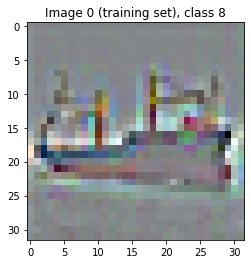

In [8]:
i = 0
plt.imshow(to_img(x_train[i]))
plt.title(f'Image {i} (training set), class {y_train[i]}')
plt.show()

0 plane, 1 car, 2 bird, 3 cat, 4 deer, 5 dog, 6 frog, 7 horse, 8 ship, 9 truck

#### Feature extraction

In [9]:
def channels_mean(X):
    """Compute the mean of the channels at each pixel"""
    size = X.shape[1] // 3

    x_r = X[:, :size]
    x_g = X[:, size: 2*size]
    x_b = X[:, 2*size:]

    return (x_r + x_g + x_b) / 3

In [10]:
x_train_means = channels_mean(x_train)
x_test_means = channels_mean(x_test)

In [11]:
class HOG:
    def __init__(self, window, bins=9):
        self.window = window
        self.bins = bins
        self.dim = None
        self.norm = None
        self.angle = None
        self.hist = None

    def gradient(self, img):
        """Compute the norm and orientation of the gradient at each pixel by 
        keeping the channel with the biggest norm for each pixel"""

        dim = img.shape[0]
        self.dim = dim

        pad_img = np.zeros((dim+2, dim+2, 3))
        pad_img[1:-1, 1:-1, :] = img
        grad_y = pad_img[:-2, 1:-1, :] - pad_img[2:, 1:-1, :] 
        grad_x = pad_img[1:-1, 2:, :] - pad_img[1:-1, :-2, :]
        norm = np.sqrt(np.square(grad_x) + np.square(grad_y))
        max_channels = np.argmax(norm, axis=2)
        norm = np.max(norm, axis=2)

        grad_x_max = np.zeros(norm.shape)
        for i in range(dim):
            for j in range(dim):
                grad_x_max[i, j] = grad_x[i, j, max_channels[i, j]]
        grad_y_max = np.zeros(norm.shape)
        for i in range(dim - 2):
            for j in range(dim - 2):
                grad_y_max[i, j] = grad_y[i, j, max_channels[i, j]]
        angle = 180 * np.arctan2(grad_y_max, grad_x_max) / np.pi
        angle = np.clip((angle < 0) * 180 + angle, 0, 180)

        self.norm = norm
        self.angle = angle

    def histogram(self, i_patch, j_patch):
        """Compute the histogram of gradient orientations for a cell"""

        hist = np.zeros(self.bins)
        for i in range(self.window):
            for j in range(self.window):
                norm = self.norm[i_patch + i, j_patch + j]
                angle = self.angle[i_patch + i, j_patch + j]
                pos = angle / 180 * self.bins
                left_bin = int(pos) % 9
                right_bin = (int(pos) + 1) % 9
                hist[left_bin] += norm * (left_bin + 1 - pos) % 9
                hist[right_bin] += norm * (pos - left_bin) % 9

        return hist
    
    def cell_hist(self):
        """Compute the histogram of gradient orientations in each cell"""

        dim_cells = self.dim // self.window
        hist = np.zeros((dim_cells, dim_cells, self.bins))
        for i in range(dim_cells):
            for j in range(dim_cells):
                hist[i, j, :] = self.histogram(i*self.window, j*self.window)

        self.hist = hist

    def features(self, img):
        """Aggregate histograms 4 by 4 and flatten bin values"""

        self.gradient(img)
        self.cell_hist()
        features = np.zeros(0)
        dim_cells = self.dim // self.window
        for i in range(dim_cells - 1):
            for j in range(dim_cells - 1):
                hist_fusion = np.concatenate([self.hist[i+ii, j+jj] for ii in range(2) for jj in range(2)])
                hist_fusion = hist_fusion / np.sqrt(np.sum(np.square(hist_fusion)))
                features = np.concatenate((features, hist_fusion))
        
        return features

In [12]:
window = 4
bins = 9
hog = HOG(window=window, bins=bins)

dim_cells = 32 // window 
n_features = 4 * bins * (dim_cells - 1)**2

x_train_hog = np.zeros((x_train.shape[0], n_features))
for i in range(x_train.shape[0]):
    x_train_hog[i] = hog.features(to_img(x_train[i]))

x_test_hog = np.zeros((x_test.shape[0], n_features))
for i in range(x_test.shape[0]):
    x_test_hog[i] = hog.features(to_img(x_test[i]))

#### Kernels

In [13]:
class Linear:
    def __init__(self):
        pass
    def kernel(self, X, Y):
        return X @ Y.T

class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma
    def kernel(self, X, Y):
        sq_dist = np.sum(X**2, axis=1)[:, None] + np.sum(Y**2, axis=1)[None, :] - 2*X @ Y.T
        return np.exp(-sq_dist / (2*self.sigma**2))

class Laplace:
    def __init__(self, sigma=1.):
        self.sigma = sigma
    def kernel(self, X, Y):
        sq_dist = np.sum(X**2, axis=1)[:, None] + np.sum(Y**2, axis=1)[None, :] - 2*X @ Y.T
        sq_dist = np.clip(sq_dist, 0, None)
        
        return np.exp(-np.sqrt(sq_dist) / (self.sigma))

class Log():
    def __init__(self, d):
        self.d = d
    def kernel(self, X, Y):
        sq_dist = np.sum(X**2, axis=1)[:, None] + np.sum(Y**2, axis=1)[None, :] - 2*X @ Y.T
        sq_dist = np.clip(sq_dist, 0, None)
        return -np.log(1 + np.sqrt(sq_dist)**self.d)

#### Binary classifier

In [14]:
class KRR:
    
    def __init__(self, kernel, lambd):                    
        self.kernel = kernel
        self.lambd = lambd
        self.K = None
        self.alpha = None
        self.basis = None
       
    def krr(self, y):
        """Compute an optimal alpha for KRR"""
        n = y.shape[0]
        alpha = np.linalg.solve(self.K + self.lambd*n*np.eye(n), y)

        return alpha

    def fit(self, X, y):
        """Update the model parameters"""
        n = len(y)
        self.K = self.kernel(X, X)
        self.basis = X
        self.alpha = self.krr(y)

    def score(self, x):
        """Real valued score function"""
        K_x = self.kernel(x, self.basis)
        return K_x @ self.alpha
    
    def predict(self, X):
        """Predict y values in {0, 1}"""
        f = self.score(X)

        return (f > 0)

#### Multi class classifier

In [15]:
class MultiClass_KRR:

    def __init__(self, kernel, lambd):
        self.kernel = kernel
        self.lambd = lambd
        self.c = None
        self.classifiers = None

    def fit(self, X, y):
        """"Fit a binary classifier for each class"""
        c = int(np.max(y)) + 1
        self.c = c
        classifiers = []
        for i in range(c):
          y_i = (y == i)
          clf = KRR(self.kernel, self.lambd)
          clf.fit(X, y_i)
          classifiers.append(clf)
        self.classifiers = classifiers
    
    def predict(self, X):
        """Predict y values in {0, 1, ..., c-1}"""
        n = X.shape[0]
        scores = np.zeros((self.c, n))
        for i in range(self.c):
          scores[i] = self.classifiers[i].score(X)
        y_pred = np.argmax(scores, axis=0)

        return y_pred

#### K-fold Cross validation

In [16]:
def split_cv(x_train, y_train, k=5):
    """Split the training data into k-fold train/validation sets"""

    size = x_train.shape[0] // k
    dim = x_train.shape[1]

    cv_x_train = np.zeros((k, (k-1) * size, dim))
    cv_x_val = np.zeros((k, size, dim))
    for i in range(k):
        cv_x_train[i] = np.delete(x_train, slice(i*size, (i+1)*size), axis=0)
        cv_x_val[i] = x_train[i*size : (i+1)*size]

    cv_y_train = np.zeros((k, (k-1) * size))
    cv_y_val = np.zeros((k, size))
    for i in range(k):
        cv_y_train[i] = np.delete(y_train, slice(i*size, (i+1)*size))
        cv_y_val[i] = y_train[i*size : (i+1)*size]

    return cv_x_train, cv_y_train, cv_x_val, cv_y_val

In [17]:
def cv(model, x_train, y_train, k=5):
    """Compute the mean accuracy after k-fold cross-validation"""

    cv_x_train, cv_y_train, cv_x_val, cv_y_val = split_cv(x_train, y_train, k)
    size = x_train.shape[0] // k
    scores = np.zeros(k)

    for i in range(k):
        model.fit(cv_x_train[i], cv_y_train[i])
        y_pred = model.predict(cv_x_val[i])
        scores[i] = (y_pred == cv_y_val[i]).sum() / size
        print(f"score : {scores[i]}")
    
    return scores.mean()

In [18]:
model = MultiClass_KRR(kernel = Log(4).kernel, lambd=1e-5)
acc = cv(model, x_train_hog, y_train, k=5)

print(f'mean: {acc}')

score : 0.561
score : 0.553
score : 0.558
score : 0.545
score : 0.593
mean: 0.562


#### Prediction on the testing set

In [19]:
def prediction(model, x_train, y_train, x_test):
    """Fit the model on the training data and predict on the testing set"""

    model.fit(x_train, y_train)
    y_test = model.predict(x_test)

    return y_test

model = MultiClass_KRR(kernel = Log(4).kernel, lambd=1e-5)

y_test = prediction(model, x_train_hog, y_train, x_test_hog)
y_test = {'Prediction' : y_test}
dataframe = pd.DataFrame(y_test)
dataframe.index += 1
dataframe.to_csv('Yte_pred.csv',index_label='Id')